# (05) Categorical—MNIST—0

**Motivation**: Categorical + MNIST. Device = ```cuda:0``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
from analysis.eval import sparse_score
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
device_idx = 0
device = f'cuda:{device_idx}'

model_type = 'categorical'

## CONV + FF

In [3]:
cfg_vae, cfg_tr = default_configs('MNIST', model_type, 'conv+b|conv+b')
cfg_vae['n_latents'] = 1

print(f"VAE:\n{cfg_vae}\n\nTrainer:\n{cfg_tr}")

VAE:
{'dataset': 'MNIST', 'n_ch': 32, 'n_latents': 1, 'n_categories': 10, 'enc_type': 'conv', 'dec_type': 'conv', 
'enc_bias': True, 'dec_bias': True}

Trainer:
{'temp_anneal_portion': 0.5, 'temp_anneal_type': 'lin', 'temp_start': 1.0, 'temp_stop': 0.1, 'lr': 0.002, 'epochs':
1000, 'batch_size': 200, 'warm_restart': 2, 'optimizer_kws': {'weight_decay': 0.0003}, 'grad_clip': 1000}

+----------------+------------+
|  Module Name   | Num Params |
+----------------+------------+
| CategoricalVAE |  6.2 Mil   |
|      ---       |    ---     |
|      stem      |    352     |
|      enc       |  4.9 Mil   |
|     fc_enc     |   2.6 K    |
|     fc_dec     |   11.3 K   |
|      dec       |  1.2 Mil   |
+----------------+------------+

categorical_c-10_MNIST_z-1_k-32_<conv+b|conv+b>
mc_b200-ep1000-lr(0.002)_beta(1:0x0.5)_temp(0.1:lin-0.5)_gr(1000)_(2024_05_05,22:50)

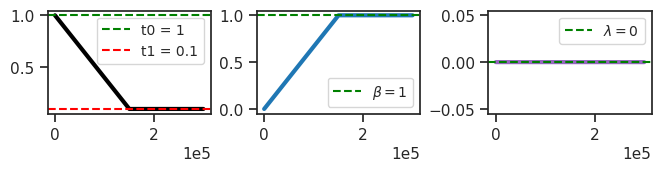

In [4]:
vae = MODEL_CLASSES[model_type](CFG_CLASSES[model_type](**cfg_vae))
tr = TrainerVAE(vae, ConfigTrainVAE(**cfg_tr), device=device)

vae.print()
print(f"{vae.cfg.name()}\n{tr.cfg.name()}_({vae.timestamp})\n")
tr.show_schedules()

In [5]:
vae.fc_dec.bias.shape, vae.fc_enc.bias.shape

(torch.Size([1024]), torch.Size([10]))

In [6]:
vae.size

(1, 10)

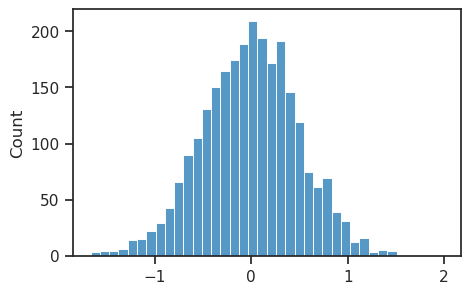

In [7]:
sns.histplot(tonp(vae.fc_enc.weight.data.ravel()));

In [8]:
vae.cfg.init_scale

0.5

In [9]:
tr.cfg.warmup_epochs

5

### Train

In [10]:
# comment = f"..._{tr.cfg.name()}"
comment = tr.cfg.name()
tr.train(comment=comment)

epoch # 1000, avg loss: 40.594954: 100%|██████████████████████| 1000/1000 [2:55:11<00:00, 10.51s/it]


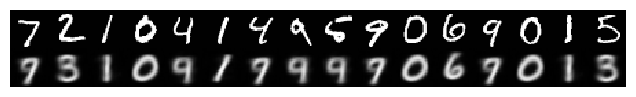

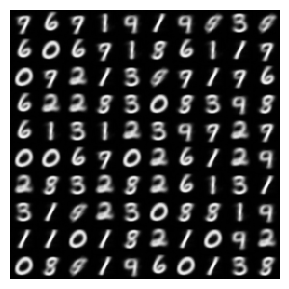

In [11]:
tr.show_recon(0.0), tr.show_samples(0.0);

### Loss vld (freeze)

In [13]:
data, loss, etc = tr.validate()

_loss = {k: v.mean() for k, v in loss.items()}
_loss['tot'] = _loss['mse'] + _loss['kl']
print(_loss)

{'mse': 40.21492, 'kl': 1.9365338, 'kl_diag': 1.9365338, 'tot': 42.151455}

### Identify dead neurons

In [14]:
dead_thres = 0.0
dead = loss['kl_diag'] < dead_thres
dead.sum()

0

In [15]:
loss['kl_diag']

array([1.9365338], dtype=float32)

### Spike counts

In [16]:
lifetime, population, percents = sparse_score(data['z'], cutoff=0.01)
print(percents)

{'0': 90.0, '1': 10.0, 'inf+': 0}

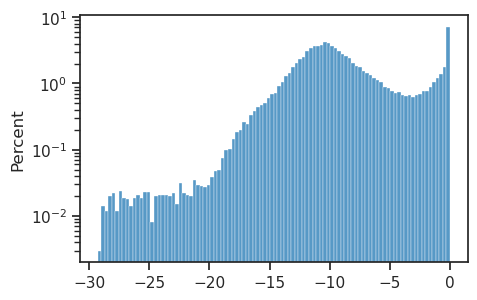

In [17]:
ax = sns.histplot(etc['logits'][:, ~dead].ravel(), stat='percent', bins=100)
ax.set_yscale('log')

In [18]:
def _show_pairwise(i, j, dim=0):
    df = pd.DataFrame({
        f'z-{i}': etc['logits'][:, dim, i],
        f'z-{j}': etc['logits'][:, dim, j],
        f'z-{i}_p': tonp(torch.sigmoid(torch.tensor(etc['logits'][:, dim, i]))),
        f'z-{j}_p': tonp(torch.sigmoid(torch.tensor(etc['logits'][:, dim, j]))),
        'lbl': tonp(tr.dl_vld.dataset.tensors[1]).astype(int),
    })
    fig, axes = create_figure(1, 2, (8, 4.5), layout='constrained')
    sns.scatterplot(data=df, x=f'z-{i}', y=f'z-{j}', hue='lbl', palette='tab10', s=20, ax=axes[0])
    sns.scatterplot(data=df, x=f'z-{i}_p', y=f'z-{j}_p', hue='lbl', palette='tab10', s=5, legend=False, ax=axes[1])
    axes[1].axvline(0, color='k', ls='--', lw=1.0, zorder=0)
    axes[1].axhline(0, color='k', ls='--', lw=1.0, zorder=0)
    ax_square(axes)
    plt.show()

In [19]:
for i, j in list(itertools.combinations(
    range(tr.model.cfg.n_latents), 2)):
    _show_pairwise(i, j)

<Axes: ylabel='Count'>

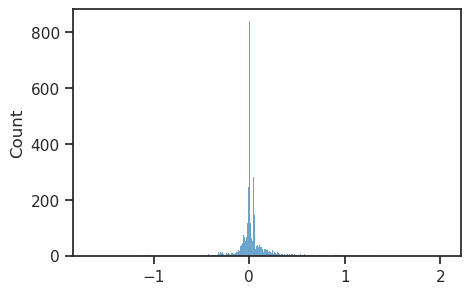

In [20]:
sns.histplot(tonp(torch.cat(vae.all_lognorm)))

In [21]:
(np.array(list(tr.stats['grad'].values())) > 500).sum() / len(tr.stats['grad'])

0.0026633333333333335

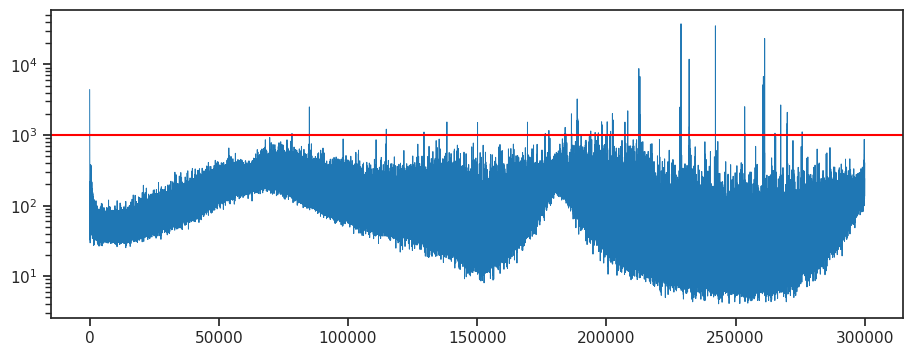

In [22]:
fig, ax = create_figure(1, 1, (11, 4))
plt.plot(tr.stats['grad'].keys(), tr.stats['grad'].values(), lw=0.7)
ax.axhline(tr.cfg.grad_clip, color='r')
ax.set(yscale='log')
plt.show()

In [23]:
df, df_summary = knn_analysis(
    x=flatten_np(etc['logits'], start_dim=1),
    y=tonp(tr.dl_vld.dataset.tensors[1]),
    n_iter=100,
    verbose=True,
)

train sample size: 20, iter #0:   0%|                             | 0/801 [00:00<?, ?it/s]/home/hadi/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hadi/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hadi/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [24]:
df_summary

,mean,std
size,,
20,0.334602,0.057268
50,0.505616,0.041738
100,0.600700,0.024582
200,0.660284,0.018944
500,0.717690,0.012717
1000,0.747566,0.008765
2000,0.776050,0.007348
4000,0.802712,0.004306
5000,0.810200,NaN
